# Simulate RAW Degradations

### https://huggingface.co/datasets/marcosv/rawir

This dataset includes images different smartphones: iPhoneX, SamsungS9, Samsung21, Google Pixel 7-9, Oppo vivo x90.

**How are the RAW images?**

- All the RAW images in this dataset have been standarized to follow a Bayer Pattern `RGGB`, and already white-black level corrected.
- Each RAW image was split into several crops of size 512x512x4 (1024x1024x3 for the corresponding RGBs). You see the filename `{raw_id}_{patch_number}.npy`.
- For each RAW image, you can find the associated metadata `{raw_id}.pkl`.
- RGB images are the corresponding captures from the phone i.e., the phone imaging pipeline (ISP) output. The images are saved as lossless PNG 8bits.
- Scenes include indoor/outdoor, day/night, different ISO levels, different shutter speed levels.

- How can I load these RAW images?

```
import numpy as np
raw = np.load("raw.npy")
max_val = 2**12 -1
raw = (raw / max_val).astype(np.float32)
```

- How do we save them?

```
import numpy as np
max_val = 2**12 -1
raw = (raw * max_val).astype(np.uint16)
np.save(os.path.join(SAVE_PATH, f"raw.npy"), raw_patch)
```

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from glob import glob
from degradations import simple_deg_simulation

sys.path.insert(0, os.path.abspath('..'))
from utils import plot_all, load_raw, postprocess_raw, demosaic

(12,)


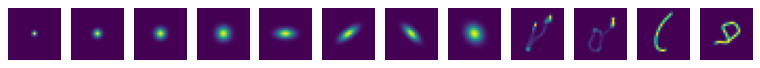

In [6]:
kernels = np.load("kernels.npy", allow_pickle=True)
print (kernels.shape)
plot_all([k for k in kernels])

In [9]:
OUT_PATH = "degraded-samples/"
RAWS     = sorted(glob('../samples/*.npy'))
MAX_VAL  = 2**12 - 1
DOWNSAMPLE = False

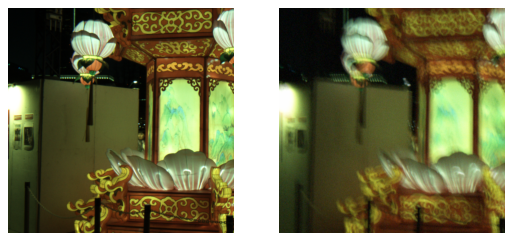

x90_3_4.npy


In [14]:
#os.makedir(OUT_PATH,  exist_ok=True)

for ni, rawf in enumerate(RAWS):
    
    raw = load_raw(rawf)
    # raw = np.load(rawf)
    # raw = (raw / MAX_VAL).astype(np.float32)

    # Apply degradations to the clean RAW (blur, noise, downsample)
    # use down = True to downsample the RAW image for Super-Resolution experiments
    raw_deg = simple_deg_simulation(raw, kernels, down=DOWNSAMPLE)

    if not DOWNSAMPLE:
        assert raw.shape == raw_deg.shape

    assert raw_deg.max() <= 1.
    assert raw_deg.min() >= 0.

    # Let's visualizr the RAW images
    raw_rgb     = postprocess_raw(demosaic(raw))
    raw_deg_rgb = postprocess_raw(demosaic(raw_deg))

    plot_all([raw_rgb, raw_deg_rgb], figsize=(8,16))
    print (os.path.basename(rawf))

    # Save the RAW image
    # raw_deg = (raw_deg * MAX_VAL).astype(np.uint16)
    # np.save(os.path.join(OUT_PATH, os.path.basename(rawf)), raw_deg)

Check several samples to calibrate the degradation pipeline

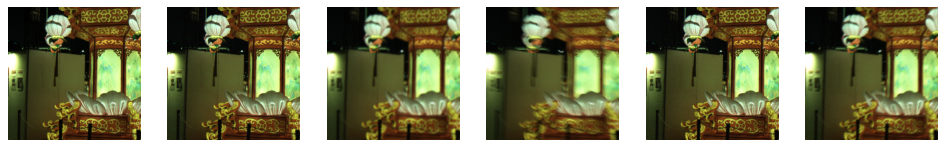

In [20]:
NVARIANTS = 5

for ni, rawf in enumerate(RAWS):
    
    raw = load_raw(rawf)
    deg_variants = []

    for _ in range(NVARIANTS):
        raw_deg = simple_deg_simulation(raw, kernels, down=DOWNSAMPLE)

        if not DOWNSAMPLE:
            assert raw.shape == raw_deg.shape

        assert raw_deg.max() <= 1.
        assert raw_deg.min() >= 0.

        raw_deg_rgb = postprocess_raw(demosaic(raw_deg))
        deg_variants.append(raw_deg_rgb)

    raw_rgb  = postprocess_raw(demosaic(raw))
    plot_all([raw_rgb]+deg_variants, figsize=(15,30))